In [22]:
# Minicons Installation
# Introduction can be found https://kanishka.xyz/post/minicons-running-large-scale-behavioral-analyses-on-transformer-lms/
# Tutorial and code can be found https://github.com/kanishkamisra/minicons/blob/master/examples/surprisals.md
#!pip install minicons

from minicons import scorer
import pandas as pd
import numpy as np
import json
import csv
import re
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import torch
from torch.utils.data import DataLoader
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

In [4]:
#model_path_10m = "gpt2-small/checkpoint-pretrainedtokenizer_10M"
#model_path = "gpt2-small/checkpoint-trainedtokenizer_10M"
model_path_10m = "gpt2-small/checkpoint-trainedtokenizer_10M_whitespace"
#model_path_100m = "gpt2-small/checkpoint-pretrainedtokenizer_100M"
#model_path = "gpt2-small/checkpoint-trainedtokenizer_100M"
model_path_100m = "gpt2-small/checkpoint-trainedtokenizer_100M_whitespace"

model_10m = GPT2LMHeadModel.from_pretrained(model_path_10m)
tokenizer_10m = GPT2TokenizerFast.from_pretrained(model_path_10m)
model_100m = GPT2LMHeadModel.from_pretrained(model_path_100m)
tokenizer_100m = GPT2TokenizerFast.from_pretrained(model_path_100m)

# wrap with minicons scorer
lm_scorer_10m = scorer.IncrementalLMScorer(model_path_10m, device = "cpu")
lm_scorer_100m = scorer.IncrementalLMScorer(model_path_100m, device = "cpu")

In [67]:
lm_scorer_gpt2 = scorer.IncrementalLMScorer('gpt2', 'cpu')

In [9]:
print("Special tokens:", tokenizer.all_special_tokens)
print("Special token IDs:", tokenizer.all_special_ids)
print("Special tokens map:", tokenizer.special_tokens_map)

Special tokens: ['<|endoftext|>']
Special token IDs: [50257]
Special tokens map: {'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}


In [12]:
surprisals

[[('<pad>', 0.0),
  ('ĠTheĠ', 6.771759033203125),
  ('balloon', 12.995538711547852),
  ('Ġwa', 3.036536693572998),
  ('s', 0.0033515978138893843),
  ('Ġinf', 14.873947143554688),
  ('lat', 3.8473756313323975),
  ('ingĠfor', 9.053845405578613),
  ('Ġ10', 10.562509536743164),
  ('Ġminute', 3.032411813735962),
  ('s', 0.0010208890307694674)]]

In [5]:
def calculate_surprisal(model_lm_scorer, sentence):
    '''
    Takes in a sentence, and outputs surprisal values for each word.
    '''
    
    input_sentence = sentence
    # token_score() function of Minicons takes in several parameters
    # if surprisal = True, the output value is surprisal instead of log likelihood
    # if base_two = True, the log likelihood will be in base 2
    # see Minicons documentations for details
    # score tokens
    token_surprisals = model_lm_scorer.token_score(input_sentence, surprisal = True, base_two = True)[0]
    #print(token_surprisals)

    '''
    # filter out special tokens (like <pad>)
    special_tokens = set(tokenizer.all_special_tokens + ['<pad>'])
    filtered = [
        (token, score)
        for (token, score) in token_surprisals
        if token not in special_tokens
    ]
    '''

   # expand tokens that contain multiple words
    expanded = []
    for token, score in token_surprisals:
    #for token, score in filtered:
        token = token.strip('Ġ') # remove space marker
        if token.count('Ġ') > 0:
            # multiple words inside
            words = token.split('Ġ')
            words = [word for word in words if word]  # remove empty strings
            for i, word in enumerate(words):
                expanded_token = word
                expanded.append((expanded_token, score / len(words)))  # split surprisal equally
        else:
            expanded.append((token, score))    
    #print(expanded)

    # use regex to split into words and punctuation
    words = re.findall(r'\w+|[^\w\s]', sentence)
    results = []

    token_pointer = 0

    for word in words:
        accumulated = ''
        word_surprisal = 0.0

        while token_pointer < len(expanded):
            token, surprisal = expanded[token_pointer]
            accumulated += token
            word_surprisal += surprisal
            token_pointer += 1

            if accumulated == word:
                results.append((word, word_surprisal))
                break
        else:
            results.append((word, word_surprisal))

    return results


sentence = 'I know that your friend gave a baguette to Mary last weekend.'
calculate_surprisal(lm_scorer_100m, sentence)

[('I', 0.0),
 ('know', 4.365269184112549),
 ('that', 3.4667656421661377),
 ('your', 9.112505912780762),
 ('friend', 6.371501922607422),
 ('gave', 10.674038887023926),
 ('a', 4.927915096282959),
 ('baguette', 38.19276142120361),
 ('to', 5.820535182952881),
 ('Mary', 13.028478622436523),
 ('last', 11.46209716796875),
 ('weekend', 7.374884128570557),
 ('.', 2.0132205486297607)]

In [15]:
def calculate_sentence_surprisal(word_surprisals):
    '''Returns total surprisal and average surprisal per word.'''
    
    scores = [score for word, score in word_surprisals]
    total = sum(scores)
    avg = total / len(scores)
    return total, avg

"""
def sum_region_surprisal(row, region_list):
    '''Sums surprisals of a specified sentence region, extracting the relevant part from sentence_surprisals using index information.'''

    sentence_surprisals = row['surprisals']
    
    # retrieve all sentence column(from 'prefix' till 'end')
    all_columns = row.index.tolist()  # get the list of column names
    prefix_index = all_columns.index('prefix')
    eos_index = all_columns.index('end')
    
    # reconstruct the full sentence from 'prefix' to 'end' (exclude NaN values)
    full_sentence = ' '.join([str(row[col]) if pd.notna(row.get(col)) else '' for col in all_columns[prefix_index:eos_index + 1]])
    
    # use regex to split the full sentence into words & punctuation
    sentence_units = re.findall(r'\w+|[^\w\s]', full_sentence)
    
    # get the start and end indices for the region_list within the full sentence
    first_region_column = region_list[0]
    first_region_start_index = all_columns.index(first_region_column)
    
    last_region_column = region_list[-1]
    last_region_end_index = all_columns.index(last_region_column)
    
    # extract the relevant slice of sentence_surprisals that corresponds to the region_list
    # calculate the starting and ending index for the region_list part
    start_index = sum([
        len(re.findall(r'\w+|[^\w\s]', str(row[col]))) for col in all_columns[prefix_index:first_region_start_index]
        if pd.notna(row[col]) 
    ])
    end_index = sum([
        len(re.findall(r'\w+|[^\w\s]', str(row[col]))) for col in all_columns[prefix_index:last_region_end_index + 1]
        if pd.notna(row[col]) 
    ])

    # extract the slice of sentence_surprisals corresponding to the region_list part
    relevant_surprisals = sentence_surprisals[start_index:end_index]
    region_surprisal = sum([score for token, score in relevant_surprisals])
    
    return region_surprisal
"""

def sum_region_surprisal(row, model_surprisals, region_list, priority_region = None, normalize = False):
    '''Sums surprisals of a specified sentence region with optional priority region handling.'''

    sentence_surprisals = row[model_surprisals]
    
    # retrieve all sentence column(from 'prefix' till 'end')
    all_columns = row.index.tolist()  # get the list of column names
    prefix_index = all_columns.index('prefix')
    eos_index = all_columns.index('end')
    
    # reconstruct the full sentence from 'prefix' to 'end' (exclude NaN values)
    full_sentence = ' '.join([str(row[col]) if pd.notna(row.get(col)) else '' for col in all_columns[prefix_index:eos_index + 1]])
    
    # use regex to split the full sentence into words & punctuation
    sentence_units = re.findall(r'\w+|[^\w\s]', full_sentence)
    
    if priority_region:
        # check if priority_region has non-zero surprisal
        if pd.notna(row[priority_region]):
            # extract text for the priority_region
            priority_region_index = all_columns.index(priority_region)
            
            start_index = sum([
                len(re.findall(r'\w+|[^\w\s]', str(row[col]))) for col in all_columns[prefix_index:priority_region_index]
                if pd.notna(row[col]) 
            ])
            end_index = sum([
                len(re.findall(r'\w+|[^\w\s]', str(row[col]))) for col in all_columns[prefix_index:priority_region_index + 1]
                if pd.notna(row[col]) 
            ])
            
            # calculate the surprisal for the priority region
            relevant_surprisals = sentence_surprisals[start_index:end_index]
            priority_surprisal = sum([score for token, score in relevant_surprisals])
    
            # return priority region's surprisal score if it is non-zero
            if priority_surprisal != 0:
                return priority_surprisal
    
    # if priority region is not provided or its surprisal is zero, calculate sum of region_list surprisals

    # get the start and end indices for the region_list within the full sentence
    first_region_column = region_list[0]
    first_region_start_index = all_columns.index(first_region_column)
    
    last_region_column = region_list[-1]
    last_region_end_index = all_columns.index(last_region_column)
    
    # extract the relevant slice of sentence_surprisals that corresponds to the region_list
    # calculate the starting and ending index for the region_list part
    start_index = sum([
        len(re.findall(r'\w+|[^\w\s]', str(row[col]))) for col in all_columns[prefix_index:first_region_start_index]
        if pd.notna(row[col]) 
    ])
    end_index = sum([
        len(re.findall(r'\w+|[^\w\s]', str(row[col]))) for col in all_columns[prefix_index:last_region_end_index + 1]
        if pd.notna(row[col]) 
    ])

    # extract the slice of sentence_surprisals corresponding to the region_list part
    relevant_surprisals = sentence_surprisals[start_index:end_index]
    region_surprisal = sum([score for token, score in relevant_surprisals])
    
    if normalize == False:
        return region_surprisal
    elif normalize == True:
        return region_surprisal / len(sentence_units)

In [6]:
def split_ends(ends):
    '''Splits off sentence-final punctuation.'''
    
    match = re.match(r'^(.*?)([.!?])$', ends.strip())
    if match:
        return pd.Series([match.group(1), match.group(2)])
    else:
        return pd.Series([ends, ''])  # no end punctuation
    
def encode_wh_licensor(df):
    '''
    Adds a numeric column to the DataFrame:
    - 1 if licensor is a wh-licensor
    - -1 otherwise (licensor is "that" or absent)
    '''
    df['wh_numeric'] = df['filler'].apply(lambda x: 1 if x > 0 else -1)
    return df

def merge_sentence(row, syntactic_parts):
    '''Merges sentence columns back into full sentence.'''
    
    parts = [row[part] for part in syntactic_parts]         
    # filter out NaN or empty parts
    non_empty_parts = [str(part) for part in parts if pd.notna(part) and str(part).strip() != '']
    # join with spaces and add end punctuation
    sentence = ' '.join(non_empty_parts) + (row['end'] if pd.notna(row['end']) else '')
    return sentence

#### Wh-licensing Term Calculation & Visualization

In [7]:
def compute_wh_licensing_interaction(df, surprisal):
    '''Calculates wh-licensing interaction term for each sentence set (per item_id).'''
    
    results = []
    for item_id in df['item_id'].unique():
        item_df = df[df['item_id'] == item_id]
        f_plus_g_minus = item_df[(item_df['wh_numeric'] == 1) & (item_df['gap_numeric'] == -1)][surprisal].mean()
        f_minus_g_minus = item_df[(item_df['wh_numeric'] == -1) & (item_df['gap_numeric'] == -1)][surprisal].mean()
        f_plus_g_plus = item_df[(item_df['wh_numeric'] == 1) & (item_df['gap_numeric'] == 1)][surprisal].mean()
        f_minus_g_plus = item_df[(item_df['wh_numeric'] == -1) & (item_df['gap_numeric'] == 1)][surprisal].mean()

        if pd.notna(f_plus_g_minus) and pd.notna(f_minus_g_plus) and pd.notna(f_plus_g_plus) and pd.notna(f_minus_g_plus):
            wh_effect = (f_plus_g_minus - f_minus_g_minus) - (f_plus_g_plus - f_minus_g_plus)
            results.append({'item_id': item_id, 'wh_effect': wh_effect})

    return pd.DataFrame(results)

In [56]:
# single plot
"""
from scipy.stats import sem

def plot_wh_licensing_interaction(df_list, labels, title):
    '''
    Plots mean wh-licensing interaction terms with color legend.

    Args:
        df_list: List of DataFrames, each with a 'wh_effect' column.
        labels: List of labels corresponding to each DataFrame.
    '''
    
    means = []
    errors = []
    colors = plt.cm.tab10.colors[:len(df_list)]  # distinct colors
    #colors = plt.cm.Set2.colors[:len(df_list)]  # pastel colors

    for df in df_list:
        mean_effect = df['wh_effect'].mean()
        stderr = sem(df['wh_effect'])
        means.append(mean_effect)
        errors.append(1.96 * stderr)  # 95% CI

    x = np.arange(len(df_list))

    plt.figure(figsize = (4, 6))
    bars = plt.bar(x, means, yerr = errors, capsize = 10, color = colors)
    plt.xticks(x, labels)
    plt.ylabel('Mean wh-licensing interaction (bits of surprisal)')
    plt.title(title)
    plt.ylim(min(0, min([m - e for m, e in zip(means, errors)]) - 1), max([m + e for m, e in zip(means, errors)]) + 1)
    
    # add a horizontal line at y = 0
    plt.axhline(0, color = 'black', linewidth = 1, linestyle = '--')

    # add legend
    #handles = [plt.Rectangle((0, 0), 1, 1, color = c) for c in colors]
    #plt.legend(handles, labels, title = 'gaps', loc = 'upper right')

    plt.show()
"""

In [8]:
# double plot

from scipy.stats import sem

def plot_wh_licensing_interaction(df_list1, subtitle1, df_list2, subtitle2, labels, title):
    '''
    Plots two sets of mean wh-licensing interaction terms side by side with color legend.

    Args:
        df_list1: List of DataFrames, each with a 'wh_effect' column for the first set.
        subtitle1: Title for the first plot.
        df_list2: List of DataFrames, each with a 'wh_effect' column for the second set.
        subtitle2: Title for the second plot.
        labels: List of labels corresponding to each DataFrame.
        title: Title for the entire figure.
    '''
    
    means1, errors1 = [], []
    means2, errors2 = [], []
    
    colors = plt.cm.tab10.colors[:max(len(df_list1), len(df_list2))]  # distinct colors, same color sequence for both plots

    # compute means and errors for df_list1
    for df in df_list1:
        mean_effect = df['wh_effect'].mean()
        stderr = sem(df['wh_effect'])
        means1.append(mean_effect)
        errors1.append(1.96 * stderr)  # 95% CI

    # compute means and errors for df_list2
    for df in df_list2:
        mean_effect = df['wh_effect'].mean()
        stderr = sem(df['wh_effect'])
        means2.append(mean_effect)
        errors2.append(1.96 * stderr)  # 95% CI

    x1 = np.arange(len(df_list1))
    x2 = np.arange(len(df_list2))

    # calculate common y-limits based on both plots to align zero line
    min_y = min(min([m - e for m, e in zip(means1, errors1)]), min([m - e for m, e in zip(means2, errors2)]))
    max_y = max(max([m + e for m, e in zip(means1, errors1)]), max([m + e for m, e in zip(means2, errors2)]))

    fig, axes = plt.subplots(1, 2, figsize = (6, 6))  # create a taller and slimmer plot

    # plot first set of bars on the first subplot
    axes[0].bar(x1, means1, yerr = errors1, capsize = 10, color = colors[:len(df_list1)])
    axes[0].set_xticks(x1)
    axes[0].set_xticklabels(labels)
    axes[0].set_ylabel('Mean Wh-Licensing Interaction (Bits of Surprisal)')
    axes[0].set_title(subtitle1)
    axes[0].set_ylim(min_y - 1, max_y + 1)  # align y-axis limits
    axes[0].axhline(0, color = 'black', linewidth = 1, linestyle = '--')  # line at y=0

    # plot second set of bars on the second subplot
    axes[1].bar(x2, means2, yerr = errors2, capsize = 10, color = colors[:len(df_list2)])
    axes[1].set_xticks(x2)
    axes[1].set_xticklabels(labels)
    #axes[1].set_ylabel('Mean Wh-Licensing Interaction (Bits of Surprisal)')
    axes[1].set_title(subtitle2)
    axes[1].set_ylim(min_y - 1, max_y + 1)  # align y-axis limits
    axes[1].axhline(0, color = 'black', linewidth = 1, linestyle = '--')  # line at y=0
    
    # remove y-axis labels and ticks from the second plot
    axes[1].set_ylabel('')
    axes[1].tick_params(axis = 'y', labelleft = False)

    # add overall title to the full plot
    fig.suptitle(title, fontsize = 16)

    plt.tight_layout()  # adjust layout to prevent overlap
    plt.subplots_adjust(top = 0.9)  # adjust the position of the overall title
    plt.show()

#### Gap Position

In [ ]:
sentence_df = pd.read_csv('test_sentences/Gap Position.csv')

In [ ]:
sentence_df = encode_wh_licensor(sentence_df)
sentence_df['gap_numeric'] = sentence_df['gap'].replace(0, -1)
sentence_df['sentence'] = sentence_df.apply(merge_sentence, axis = 1)
sentence_df['surprisals_10m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_10m, x))
sentence_df['surprisals_100m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_100m, x))
sentence_df

Subject Position

In [ ]:
subject_df = sentence_df.copy()

In [ ]:
subject_df['region_surprisal_10m'] = subject_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_10m', ['verb']), axis = 1)
subject_df['region_surprisal_100m'] = subject_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_100m', ['verb']), axis = 1)

In [ ]:
# filter for subject gap
subject_df = subject_df[subject_df['gap_position'] == 'subject']

Object Position

In [ ]:
object_df = sentence_df.copy()

In [ ]:
object_df['region_surprisal_10m'] = object_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_10m', ['prep']), axis = 1)
object_df['region_surprisal_100m'] = object_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_100m', ['prep']), axis = 1)

In [ ]:
# filter for object gap
object_df = object_df[object_df['gap_position'] == 'object']

PP/Goal Position

In [ ]:
pp_df = sentence_df.copy()

In [ ]:
pp_df['region_surprisal_10m'] = pp_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_10m', ['end']), axis = 1)
pp_df['region_surprisal_100m'] = pp_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_100m', ['end']), axis = 1)

In [ ]:
# filter for pp gap
pp_df = pp_df[pp_df['gap_position'] == 'PP']

Embedded Clause

In [ ]:
embed = ['apositive', 'NP1', 'verb', 'NP2', 'prep', 'NP3', 'end']
sentence_df['embed_surprisal_10m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_10m', embed, normalize = True), axis = 1)
sentence_df['embed_surprisal_100m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_100m', embed, normalize = True), axis = 1)

#### Gap Distance

In [22]:
sentence_df = pd.read_csv('test_sentences/Gap Distance.csv')
sentence_df['gap_distance'] = sentence_df['gap_distance'].fillna('null')
#sentence_df['gap_distance'].dropna(inplace = True)
#sentence_df = sentence_df[sentence_df['gap_distance'].replace(['nan', 'NaN'], np.nan).notna()]

In [23]:
sentence_df[['temp_mod', 'end']] = sentence_df['temp_mod'].apply(split_ends)
sentence_df = encode_wh_licensor(sentence_df)
sentence_df['gap_numeric'] = sentence_df['gap'].replace(0, -1)
syntactic_parts = ['prefix', 'licensor', 'subj', 'modifier', 'verb', 'object', 'prep', 'goal', 'temp_mod']
sentence_df['sentence'] = sentence_df.apply(lambda x: merge_sentence(x, syntactic_parts), axis = 1)
sentence_df['surprisals_10m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_10m, x))
sentence_df['surprisals_100m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_100m, x))
#sentence_df['surprisals_gpt2'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_gpt2, x))
#sentence_df['surprisals_gpt3'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_gpt3, x))

In [10]:
from scipy.stats import linregress

def plot_scatter_with_regression(df_list1, subtitle1, df_list2, subtitle2, labels, title):
    '''
    Plots two sets of scatter plots with regression lines, using gap_distance_length as x-axis and wh_effect as y-axis.

    Args:
        df_list1: List of DataFrames, each with 'gap_distance_length' and 'wh_effect' columns for the first set.
        subtitle1: Title for the first plot.
        df_list2: List of DataFrames, each with 'gap_distance_length' and 'wh_effect' columns for the second set.
        subtitle2: Title for the second plot.
        labels: List of labels corresponding to each DataFrame.
        title: Title for the entire figure.
    '''
    
    fig, axes = plt.subplots(1, 2, figsize = (12, 6))  # Create a figure with 2 subplots

    # Plot first set of scatter plots on the first subplot
    for df, label in zip(df_list1, labels):
        x = df['gap_distance_length']
        y = df['wh_effect']
        
        # Scatter plot
        axes[0].scatter(x, y, label=label)
        
        # Fit regression line
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        axes[0].plot(x, slope * x + intercept, color='black', linewidth=1, linestyle='--', label=f"Fit: y={slope:.2f}x + {intercept:.2f}")
    
    axes[0].set_xlabel('Gap Distance Length')
    axes[0].set_ylabel('Wh-Licensing Interaction (Bits of Surprisal)')
    axes[0].set_title(subtitle1)
    axes[0].legend()
    
    # Plot second set of scatter plots on the second subplot
    for df, label in zip(df_list2, labels):
        x = df['gap_distance_length']
        y = df['wh_effect']
        
        # Scatter plot
        axes[1].scatter(x, y, label=label)
        
        # Fit regression line
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        axes[1].plot(x, slope * x + intercept, color='black', linewidth=1, linestyle='--', label=f"Fit: y={slope:.2f}x + {intercept:.2f}")
    
    axes[1].set_xlabel('Gap Distance Length')
    axes[1].set_ylabel('Wh-Licensing Interaction (Bits of Surprisal)')
    axes[1].set_title(subtitle2)
    axes[1].legend()

    # Add overall title to the full plot
    fig.suptitle(title, fontsize = 16)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.subplots_adjust(top = 0.9)  # Adjust the position of the overall title
    plt.show()


Gap Position == Object

In [ ]:
# modifier: short_mod, med_mod, long_mod

In [24]:
"""
# region surprisals are kept separate, in long format
# create long-format rows
region_rows = []
for region in ['prep', 'goal']:
    region_df = sentence_df.copy()
    region_df['region'] = region 
    region_df['region_surprisal_10m'] = region_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_10m', [region]), axis = 1)
    region_df['region_surprisal_100m'] = region_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_100m', [region]), axis = 1)
    region_rows.append(region_df)

# concatenate long-format DataFrame
long_df = pd.concat(region_rows, ignore_index = True)

# filter for object gap
objectgap_df = long_df[long_df['gap_position'] == 'DO']
objectgap_df
"""

,item_id,condition,filler,gap_distance,gap,DO_gap,IO_gap,prefix,licensor,subj,...,gap_position,end,wh_numeric,gap_numeric,sentence,surprisals_10m,surprisals_100m,region,region_surprisal_10m,region_surprisal_100m
0,1,1,0,null,0,0,0,The manager predicts,that,the intern,...,DO,.,-1,-1,The manager predicts that the intern forwarded...,"[(The, 0.0), (manager, 14.456515312194824), (p...","[(The, 0.0), (manager, 11.191156387329102), (p...",prep,4.982591,2.627493
1,1,2,0,short,0,0,0,The manager predicts,that,the intern,...,DO,.,-1,-1,The manager predicts that the intern who you a...,"[(The, 0.0), (manager, 14.456515312194824), (p...","[(The, 0.0), (manager, 11.191156387329102), (p...",prep,5.721556,2.458865
2,1,3,0,medium,0,0,0,The manager predicts,that,the intern,...,DO,.,-1,-1,The manager predicts that the intern who you w...,"[(The, 0.0), (manager, 14.456515312194824), (p...","[(The, 0.0), (manager, 11.191156387329102), (p...",prep,6.655588,2.568919
3,1,4,0,long,0,0,0,The manager predicts,that,the intern,...,DO,.,-1,-1,The manager predicts that the intern who you r...,"[(The, 0.0), (manager, 14.456515312194824), (p...","[(The, 0.0), (manager, 11.191156387329102), (p...",prep,5.667913,2.287273
8,1,9,0,null,1,1,0,The manager predicts,that,the intern,...,DO,.,-1,1,The manager predicts that the intern forwarded...,"[(The, 0.0), (manager, 14.456513404846191), (p...","[(The, 0.0), (manager, 11.191156387329102), (p...",prep,8.603174,2.033572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,20,20,1,long,0,0,0,It was reported,what,the official,...,DO,.,1,-1,It was reported what the official who coordina...,"[(It, 0.0), (was, 4.637780666351318), (reporte...","[(It, 0.0), (was, 3.0059664249420166), (report...",goal,52.794300,42.282419
1268,20,21,1,null,1,1,0,It was reported,what,the official,...,DO,.,1,1,It was reported what the official allocated to...,"[(It, 0.0), (was, 4.637780666351318), (reporte...","[(It, 0.0), (was, 3.0059664249420166), (report...",goal,54.518299,42.558905
1269,20,22,1,short,1,1,0,It was reported,what,the official,...,DO,.,1,1,It was reported what the official who oversaw ...,"[(It, 0.0), (was, 4.637780666351318), (reporte...","[(It, 0.0), (was, 3.0059664249420166), (report...",goal,55.275697,39.784677
1270,20,23,1,medium,1,1,0,It was reported,what,the official,...,DO,.,1,1,It was reported what the official who briefed ...,"[(It, 0.0), (was, 4.637780666351318), (reporte...","[(It, 0.0), (was, 3.0059664249420166), (report...",goal,58.057873,43.953444


In [24]:
object_df = sentence_df.copy()
#object_df['region_surprisal_10m'] = object_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_10m', ['prep', 'goal']), axis = 1)
#object_df['region_surprisal_100m'] = object_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_100m', ['prep', 'goal']), axis = 1)
object_df['region_surprisal_10m'] = object_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_10m', ['prep', 'goal'], 'object'), axis = 1)
object_df['region_surprisal_100m'] = object_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_100m', ['prep', 'goal'], 'object'), axis = 1)
#object_df['region_surprisal_gpt2'] = object_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2', ['prep', 'goal'], 'object'), axis = 1)

# filter for object gap
objectgap_df = object_df[object_df['gap_position'] == 'DO']

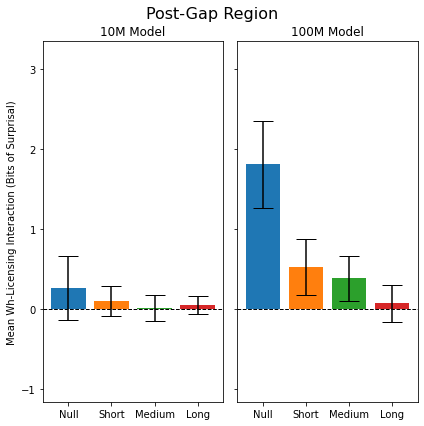

In [25]:
null_df = objectgap_df[(objectgap_df['gap_distance'] == 'null')]
short_df = objectgap_df[(objectgap_df['gap_distance'] == 'short')]
medium_df = objectgap_df[(objectgap_df['gap_distance'] == 'medium')]
long_df = objectgap_df[(objectgap_df['gap_distance'] == 'long')]
null_wh_effect_df_10m = compute_wh_licensing_interaction(null_df, 'region_surprisal_10m')
short_wh_effect_df_10m = compute_wh_licensing_interaction(short_df, 'region_surprisal_10m')
medium_wh_effect_df_10m = compute_wh_licensing_interaction(medium_df, 'region_surprisal_10m')
long_wh_effect_df_10m = compute_wh_licensing_interaction(long_df, 'region_surprisal_10m')
null_wh_effect_df_100m = compute_wh_licensing_interaction(null_df, 'region_surprisal_100m')
short_wh_effect_df_100m = compute_wh_licensing_interaction(short_df, 'region_surprisal_100m')
medium_wh_effect_df_100m = compute_wh_licensing_interaction(medium_df, 'region_surprisal_100m')
long_wh_effect_df_100m = compute_wh_licensing_interaction(long_df, 'region_surprisal_100m')
df_list_10m = [null_wh_effect_df_10m, short_wh_effect_df_10m, medium_wh_effect_df_10m, long_wh_effect_df_10m]
df_list_100m = [null_wh_effect_df_100m, short_wh_effect_df_100m, medium_wh_effect_df_100m, long_wh_effect_df_100m]
plot_wh_licensing_interaction(df_list_10m, '10M Model', df_list_100m, '100M Model', ['Null', 'Short', 'Medium', 'Long'], 'Post-Gap Region')

In [ ]:
null_df = objectgap_df[(objectgap_df['gap_distance'] == 'null')]
short_df = objectgap_df[(objectgap_df['gap_distance'] == 'short')]
medium_df = objectgap_df[(objectgap_df['gap_distance'] == 'medium')]
long_df = objectgap_df[(objectgap_df['gap_distance'] == 'long')]
null_wh_effect_df_10m = compute_wh_licensing_interaction(null_df, 'region_surprisal_gpt2')
short_wh_effect_df_10m = compute_wh_licensing_interaction(short_df, 'region_surprisal_gpt2')
medium_wh_effect_df_10m = compute_wh_licensing_interaction(medium_df, 'region_surprisal_gpt2')
long_wh_effect_df_10m = compute_wh_licensing_interaction(long_df, 'region_surprisal_gpt2')
null_wh_effect_df_100m = compute_wh_licensing_interaction(null_df, 'region_surprisal_100m')
short_wh_effect_df_100m = compute_wh_licensing_interaction(short_df, 'region_surprisal_100m')
medium_wh_effect_df_100m = compute_wh_licensing_interaction(medium_df, 'region_surprisal_100m')
long_wh_effect_df_100m = compute_wh_licensing_interaction(long_df, 'region_surprisal_100m')
df_list_10m = [null_wh_effect_df_10m, short_wh_effect_df_10m, medium_wh_effect_df_10m, long_wh_effect_df_10m]
df_list_100m = [null_wh_effect_df_100m, short_wh_effect_df_100m, medium_wh_effect_df_100m, long_wh_effect_df_100m]
plot_wh_licensing_interaction(df_list_10m, 'GPT2 Model', df_list_100m, '100M Model', ['Null', 'Short', 'Medium', 'Long'], 'Post-Gap Region')

In [ ]:
# Assuming you have two sets of DataFrames (df_list1, df_list2) with 'gap_distance_length' and 'wh_effect' columns, and a list of labels
plot_scatter_with_regression(df_list1, 'First Scatter Plot', df_list2, 'Second Scatter Plot', labels, 'Overall Scatter Plot Title')


Gap Postion == PP/Goal

In [26]:
pp_df = sentence_df.copy()
#pp_df['region_surprisal_10m'] = pp_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_10m', ['temp_mod']), axis = 1)
#pp_df['region_surprisal_100m'] = pp_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_100m', ['temp_mod']), axis = 1)
pp_df['region_surprisal_10m'] = pp_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_10m', ['temp_mod'], 'goal'), axis = 1)
pp_df['region_surprisal_100m'] = pp_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_100m', ['temp_mod'], 'goal'), axis = 1)
#pp_df['region_surprisal_gpt2'] = pp_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2', ['temp_mod'], 'goal'), axis = 1)

# filter for PP gap
ppgap_df = pp_df[pp_df['gap_position'] == 'IO']

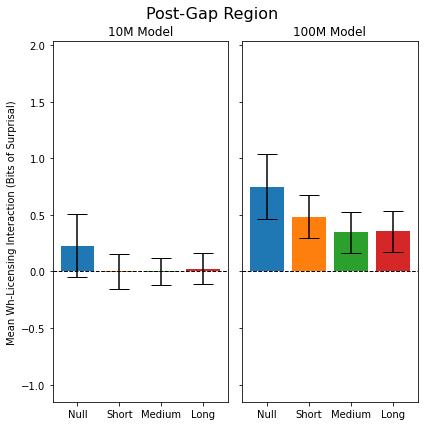

In [27]:
null_df = ppgap_df[(ppgap_df['gap_distance'] == 'null')]
short_df = ppgap_df[(ppgap_df['gap_distance'] == 'short')]
medium_df = ppgap_df[(ppgap_df['gap_distance'] == 'medium')]
long_df = ppgap_df[(ppgap_df['gap_distance'] == 'long')]
null_wh_effect_df_10m = compute_wh_licensing_interaction(null_df, 'region_surprisal_10m')
short_wh_effect_df_10m = compute_wh_licensing_interaction(short_df, 'region_surprisal_10m')
medium_wh_effect_df_10m = compute_wh_licensing_interaction(medium_df, 'region_surprisal_10m')
long_wh_effect_df_10m = compute_wh_licensing_interaction(long_df, 'region_surprisal_10m')
null_wh_effect_df_100m = compute_wh_licensing_interaction(null_df, 'region_surprisal_100m')
short_wh_effect_df_100m = compute_wh_licensing_interaction(short_df, 'region_surprisal_100m')
medium_wh_effect_df_100m = compute_wh_licensing_interaction(medium_df, 'region_surprisal_100m')
long_wh_effect_df_100m = compute_wh_licensing_interaction(long_df, 'region_surprisal_100m')
df_list_10m = [null_wh_effect_df_10m, short_wh_effect_df_10m, medium_wh_effect_df_10m, long_wh_effect_df_10m]
df_list_100m = [null_wh_effect_df_100m, short_wh_effect_df_100m, medium_wh_effect_df_100m, long_wh_effect_df_100m]
plot_wh_licensing_interaction(df_list_10m, '10M Model', df_list_100m, '100M Model', ['Null', 'Short', 'Medium', 'Long'], 'Post-Gap Region')

In [ ]:
null_df = ppgap_df[(ppgap_df['gap_distance'] == 'null')]
short_df = ppgap_df[(ppgap_df['gap_distance'] == 'short')]
medium_df = ppgap_df[(ppgap_df['gap_distance'] == 'medium')]
long_df = ppgap_df[(ppgap_df['gap_distance'] == 'long')]
null_wh_effect_df_10m = compute_wh_licensing_interaction(null_df, 'region_surprisal_gpt2')
short_wh_effect_df_10m = compute_wh_licensing_interaction(short_df, 'region_surprisal_gpt2')
medium_wh_effect_df_10m = compute_wh_licensing_interaction(medium_df, 'region_surprisal_gpt2')
long_wh_effect_df_10m = compute_wh_licensing_interaction(long_df, 'region_surprisal_gpt2')
null_wh_effect_df_100m = compute_wh_licensing_interaction(null_df, 'region_surprisal_100m')
short_wh_effect_df_100m = compute_wh_licensing_interaction(short_df, 'region_surprisal_100m')
medium_wh_effect_df_100m = compute_wh_licensing_interaction(medium_df, 'region_surprisal_100m')
long_wh_effect_df_100m = compute_wh_licensing_interaction(long_df, 'region_surprisal_100m')
df_list_10m = [null_wh_effect_df_10m, short_wh_effect_df_10m, medium_wh_effect_df_10m, long_wh_effect_df_10m]
df_list_100m = [null_wh_effect_df_100m, short_wh_effect_df_100m, medium_wh_effect_df_100m, long_wh_effect_df_100m]
plot_wh_licensing_interaction(df_list_10m, 'GPT2 Model', df_list_100m, '100M Model', ['Null', 'Short', 'Medium', 'Long'], 'Post-Gap Region')

Embedded Clause

In [28]:
embed = ['subj', 'modifier', 'verb', 'object', 'prep', 'goal', 'temp_mod', 'end']
sentence_df['embed_surprisal_10m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_10m', embed, normalize = True), axis = 1)
sentence_df['embed_surprisal_100m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_100m', embed, normalize = True), axis = 1)

Embedded Clause - Object Gap Position

In [29]:
# filter for object gap
embed_objectgap_df = sentence_df[sentence_df['gap_position'] == 'DO']

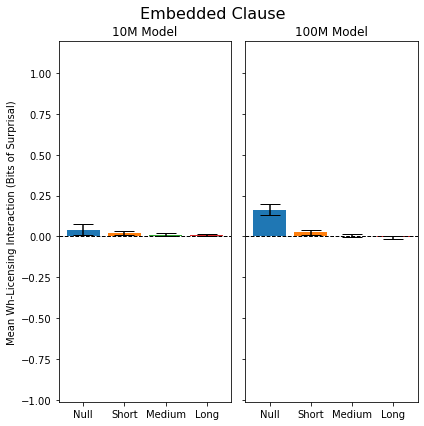

In [30]:
null_df = embed_objectgap_df[(embed_objectgap_df['gap_distance'] == 'null')]
short_df = embed_objectgap_df[(embed_objectgap_df['gap_distance'] == 'short')]
medium_df = embed_objectgap_df[(embed_objectgap_df['gap_distance'] == 'medium')]
long_df = embed_objectgap_df[(embed_objectgap_df['gap_distance'] == 'long')]
null_wh_effect_df_10m = compute_wh_licensing_interaction(null_df, 'embed_surprisal_10m')
short_wh_effect_df_10m = compute_wh_licensing_interaction(short_df, 'embed_surprisal_10m')
medium_wh_effect_df_10m = compute_wh_licensing_interaction(medium_df, 'embed_surprisal_10m')
long_wh_effect_df_10m = compute_wh_licensing_interaction(long_df, 'embed_surprisal_10m')
null_wh_effect_df_100m = compute_wh_licensing_interaction(null_df, 'embed_surprisal_100m')
short_wh_effect_df_100m = compute_wh_licensing_interaction(short_df, 'embed_surprisal_100m')
medium_wh_effect_df_100m = compute_wh_licensing_interaction(medium_df, 'embed_surprisal_100m')
long_wh_effect_df_100m = compute_wh_licensing_interaction(long_df, 'embed_surprisal_100m')
df_list_10m = [null_wh_effect_df_10m, short_wh_effect_df_10m, medium_wh_effect_df_10m, long_wh_effect_df_10m]
df_list_100m = [null_wh_effect_df_100m, short_wh_effect_df_100m, medium_wh_effect_df_100m, long_wh_effect_df_100m]
plot_wh_licensing_interaction(df_list_10m, '10M Model', df_list_100m, '100M Model', ['Null', 'Short', 'Medium', 'Long'], 'Embedded Clause')

Embedded Clause - PP/Goal Gap Position

In [31]:
# filter for PP gap
embed_ppgap_df = sentence_df[sentence_df['gap_position'] == 'IO']

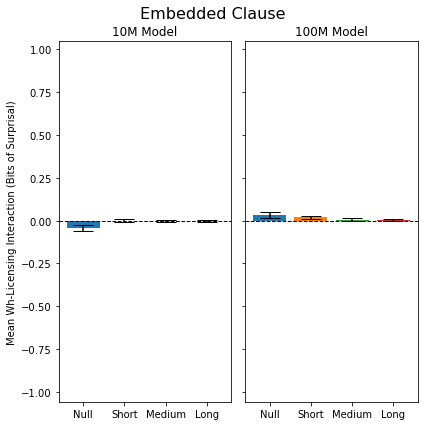

In [32]:
null_df = embed_ppgap_df[(embed_ppgap_df['gap_distance'] == 'null')]
short_df = embed_ppgap_df[(embed_ppgap_df['gap_distance'] == 'short')]
medium_df = embed_ppgap_df[(embed_ppgap_df['gap_distance'] == 'medium')]
long_df = embed_ppgap_df[(embed_ppgap_df['gap_distance'] == 'long')]
null_wh_effect_df_10m = compute_wh_licensing_interaction(null_df, 'embed_surprisal_10m')
short_wh_effect_df_10m = compute_wh_licensing_interaction(short_df, 'embed_surprisal_10m')
medium_wh_effect_df_10m = compute_wh_licensing_interaction(medium_df, 'embed_surprisal_10m')
long_wh_effect_df_10m = compute_wh_licensing_interaction(long_df, 'embed_surprisal_10m')
null_wh_effect_df_100m = compute_wh_licensing_interaction(null_df, 'embed_surprisal_100m')
short_wh_effect_df_100m = compute_wh_licensing_interaction(short_df, 'embed_surprisal_100m')
medium_wh_effect_df_100m = compute_wh_licensing_interaction(medium_df, 'embed_surprisal_100m')
long_wh_effect_df_100m = compute_wh_licensing_interaction(long_df, 'embed_surprisal_100m')
df_list_10m = [null_wh_effect_df_10m, short_wh_effect_df_10m, medium_wh_effect_df_10m, long_wh_effect_df_10m]
df_list_100m = [null_wh_effect_df_100m, short_wh_effect_df_100m, medium_wh_effect_df_100m, long_wh_effect_df_100m]
plot_wh_licensing_interaction(df_list_10m, '10M Model', df_list_100m, '100M Model', ['Null', 'Short', 'Medium', 'Long'], 'Embedded Clause')

#### Double Gaps

In [9]:
sentence_df = pd.read_csv('test_sentences/Double Gaps.csv')

In [10]:
sentence_df[['modifier', 'end']] = sentence_df['modifier'].apply(split_ends)
sentence_df = encode_wh_licensor(sentence_df)
sentence_df['gap_numeric'] = sentence_df['gap'].replace(0, -1)
syntactic_parts = ['prefix', 'licensor', 'subj', 'verb', 'object', 'modifier']
sentence_df['sentence'] = sentence_df.apply(lambda x: merge_sentence(x, syntactic_parts), axis = 1)
sentence_df['surprisals_10m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_10m, x))
sentence_df['surprisals_100m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_100m, x))
#sentence_df['surprisals_gpt2'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_gpt2, x))

In [52]:
#sentence_df.to_csv(('test_sentences/Double Gap Construction.csv'), index = False)
#sentence_df = pd.read_csv('test_sentences/Double Gap.csv')

In [11]:
def compute_wh_licensing_interaction_double_gap(df, surprisal):
    '''Calculates wh-licensing interaction term for each sentence set (per item_id).'''
    
    results = []
    for item_id in df['item_id'].unique():
        item_df = df[df['item_id'] == item_id]
        f_plus_g_minus = item_df[(item_df['wh_numeric'] == 1) & (item_df['gap_numeric'] == -1)][surprisal].mean()
        f_minus_g_minus = item_df[(item_df['wh_numeric'] == -1) & (item_df['gap_numeric'] == -1)][surprisal].mean()
        f_plus_g_plus = item_df[(item_df['wh_numeric'] == 1) & (item_df['gap_numeric'] == 1)][surprisal].mean()
        f_minus_g_plus = item_df[(item_df['wh_numeric'] == -1) & (item_df['gap_numeric'] == 1)][surprisal].mean()

        if pd.notna(f_plus_g_minus) and pd.notna(f_minus_g_minus) and pd.notna(f_plus_g_plus) and pd.notna(f_minus_g_plus):
            wh_effect = (f_plus_g_minus - f_minus_g_minus) - (f_plus_g_plus - f_minus_g_plus)
            results.append({'item_id': item_id, 'wh_effect': wh_effect})

    return pd.DataFrame(results)

Post-Gap Region - Modifier

In [25]:
#sentence_df['region_surprisal_10m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_10m', ['modifier']), axis = 1)
#sentence_df['region_surprisal_100m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_100m', ['modifier']), axis = 1)
sentence_df['region_surprisal_10m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_10m', ['modifier'], 'object'), axis = 1)
sentence_df['region_surprisal_100m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_100m', ['modifier'], 'object'), axis = 1)
#sentence_df['region_surprisal_gpt2'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2', ['modifier'], 'object'), axis = 1)

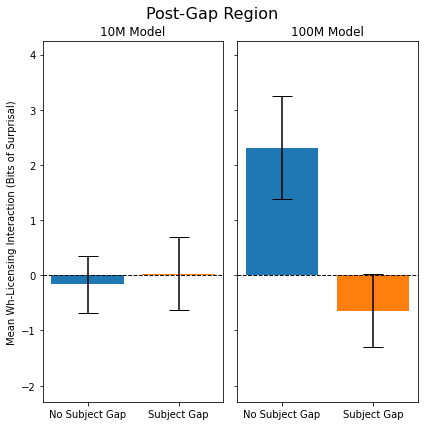

In [18]:
no_subject_gap_df = sentence_df[~((sentence_df['subject_gap'] == 1))]
subject_gap_df = sentence_df[(sentence_df['subject_gap'] == 1)]
no_gap_wh_effect_df_10m = compute_wh_licensing_interaction_double_gap(no_subject_gap_df, 'region_surprisal_10m')
gap_wh_effect_df_10m = compute_wh_licensing_interaction_double_gap(subject_gap_df, 'region_surprisal_10m')
no_gap_wh_effect_df_100m = compute_wh_licensing_interaction_double_gap(no_subject_gap_df, 'region_surprisal_100m')
gap_wh_effect_df_100m = compute_wh_licensing_interaction_double_gap(subject_gap_df, 'region_surprisal_100m')
df_list_10m = [no_gap_wh_effect_df_10m, gap_wh_effect_df_10m]
df_list_100m = [no_gap_wh_effect_df_100m, gap_wh_effect_df_100m]
plot_wh_licensing_interaction(df_list_10m, '10M Model', df_list_100m, '100M Model', ['No Subject Gap', 'Subject Gap'], 'Post-Gap Region')

In [ ]:
no_subject_gap_df = sentence_df[~((sentence_df['subject_gap'] == 1))]
subject_gap_df = sentence_df[(sentence_df['subject_gap'] == 1)]
no_gap_wh_effect_df_10m = compute_wh_licensing_interaction_double_gap(no_subject_gap_df, 'region_surprisal_gpt2')
gap_wh_effect_df_10m = compute_wh_licensing_interaction_double_gap(subject_gap_df, 'region_surprisal_gpt2')
no_gap_wh_effect_df_100m = compute_wh_licensing_interaction_double_gap(no_subject_gap_df, 'region_surprisal_100m')
gap_wh_effect_df_100m = compute_wh_licensing_interaction_double_gap(subject_gap_df, 'region_surprisal_100m')
df_list_10m = [no_gap_wh_effect_df_10m, gap_wh_effect_df_10m]
df_list_100m = [no_gap_wh_effect_df_100m, gap_wh_effect_df_100m]
plot_wh_licensing_interaction(df_list_10m, 'GPT2 Model', df_list_100m, '100M Model', ['No Subject Gap', 'Subject Gap'], 'Post-Gap Region')

Subject Gap Position

In [ ]:
subjectgap_df = sentence_df[sentence_df['condition'].isin(['a', 'b', 'd', 'e', 'f', 'h'])]

In [ ]:
no_object_gap_df =subjectgap_df[subjectgap_df['object_gap'] == 0]
object_gap_df = subjectgap_df[subjectgap_df['object_gap'] == 1]
no_gap_wh_effect_df_10m = compute_wh_licensing_interaction(no_object_gap_df, 'region_surprisal_10m')
gap_wh_effect_df_10m = compute_wh_licensing_interaction(object_gap_df, 'region_surprisal_10m')
no_gap_wh_effect_df_100m = compute_wh_licensing_interaction(no_object_gap_df, 'region_surprisal_100m')
gap_wh_effect_df_100m = compute_wh_licensing_interaction(object_gap_df, 'region_surprisal_100m')
df_list_10m = [no_gap_wh_effect_df_10m, gap_wh_effect_df_10m]
df_list_100m = [no_gap_wh_effect_df_100m, gap_wh_effect_df_100m]
plot_wh_licensing_interaction(df_list_10m, '10M Model', df_list_100m, '100M Model', ['No Object Gap', 'Object Gap'], 'Post-Gap Region')

Object Gap Position

In [23]:
objectgap_df = sentence_df[sentence_df['condition'].isin(['a', 'c', 'd', 'e', 'g', 'h'])]

In [28]:
subject_gap_df

,item_id,condition,filler,gap,subject_gap,object_gap,prefix,licensor,subj,verb,...,end,wh_numeric,gap_numeric,sentence,surprisals_10m,surprisals_100m,region_surprisal_10m,region_surprisal_100m,embed_surprisal_10m,embed_surprisal_100m
3,1,d,0,1,1,1,James realized,that,NaN,chased,...,.,-1,1,James realized that chased through the yard.,"[(James, 0.0), (realized, 15.095725059509277),...","[(James, 0.0), (realized, 15.564455032348633),...",21.725585,18.516019,6.406068,5.401046
7,1,h,1,1,1,1,James realized,what,NaN,chased,...,.,1,1,James realized what chased through the yard.,"[(James, 0.0), (realized, 15.095725059509277),...","[(James, 0.0), (realized, 15.564455032348633),...",22.146754,18.425311,6.443653,5.152464
11,2,d,0,1,1,1,The students think,that,NaN,caught,...,.,-1,1,The students think that caught under the couch.,"[(The, 0.0), (students, 15.219087600708008), (...","[(The, 0.0), (students, 12.658129692077637), (...",22.117301,25.575396,5.611354,5.049404
15,2,h,1,1,1,1,The students think,what,NaN,caught,...,.,1,1,The students think what caught under the couch.,"[(The, 0.0), (students, 15.219087600708008), (...","[(The, 0.0), (students, 12.658129692077637), (...",21.473595,24.492711,5.549529,5.036517
19,3,d,0,1,1,1,Mary realized,that,NaN,ate,...,.,-1,1,Mary realized that ate from the garden.,"[(Mary, 0.0), (realized, 16.360729217529297), ...","[(Mary, 0.0), (realized, 12.15174388885498), (...",21.339493,18.388344,5.694898,5.083196
23,3,h,1,1,1,1,Mary realized,what,NaN,ate,...,.,1,1,Mary realized what ate from the garden.,"[(Mary, 0.0), (realized, 16.360729217529297), ...","[(Mary, 0.0), (realized, 12.15174388885498), (...",18.900930,20.642056,5.565201,5.052564
27,4,d,0,1,1,1,John knows,that,NaN,found,...,.,-1,1,John knows that found in the alley.,"[(John, 0.0), (knows, 17.348905563354492), (th...","[(John, 0.0), (knows, 13.538280487060547), (th...",24.281497,17.857513,6.106512,4.584126
31,4,h,1,1,1,1,John knows,what,NaN,found,...,.,1,1,John knows what found in the alley.,"[(John, 0.0), (knows, 17.348905563354492), (wh...","[(John, 0.0), (knows, 13.538280487060547), (wh...",21.679694,14.850624,5.709291,4.081635
35,5,d,0,1,1,1,The children know,that,NaN,chose,...,.,-1,1,The children know that chose from the crowd.,"[(The, 0.0), (children, 12.961807250976562), (...","[(The, 0.0), (children, 8.045130729675293), (k...",24.789338,22.029623,5.568659,4.939035
39,5,h,1,1,1,1,The children know,what,NaN,chose,...,.,1,1,The children know what chose from the crowd.,"[(The, 0.0), (children, 12.961807250976562), (...","[(The, 0.0), (children, 8.045130729675293), (k...",24.485790,21.368654,5.580847,4.833777


In [26]:
no_subject_gap_df =objectgap_df[objectgap_df['subject_gap'] == 0]
subject_gap_df = objectgap_df[objectgap_df['subject_gap'] == 1]
no_gap_wh_effect_df_10m = compute_wh_licensing_interaction(no_subject_gap_df, 'region_surprisal_10m')
gap_wh_effect_df_10m = compute_wh_licensing_interaction(subject_gap_df, 'region_surprisal_10m')
no_gap_wh_effect_df_100m = compute_wh_licensing_interaction(no_subject_gap_df, 'region_surprisal_100m')
gap_wh_effect_df_100m = compute_wh_licensing_interaction(subject_gap_df, 'region_surprisal_100m')
df_list_10m = [no_gap_wh_effect_df_10m, gap_wh_effect_df_10m]
df_list_100m = [no_gap_wh_effect_df_100m, gap_wh_effect_df_100m]
plot_wh_licensing_interaction(df_list_10m, '10M Model', df_list_100m, '100M Model', ['No Subject Gap', 'Subject Gap'], 'Post-Gap Region')

KeyError: 'wh_effect'

Embedded Clause

In [20]:
embed = ['subj', 'object', 'verb', 'modifier', 'end']
sentence_df['embed_surprisal_10m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_10m', embed, normalize = True), axis = 1)
sentence_df['embed_surprisal_100m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_100m', embed, normalize = True), axis = 1)

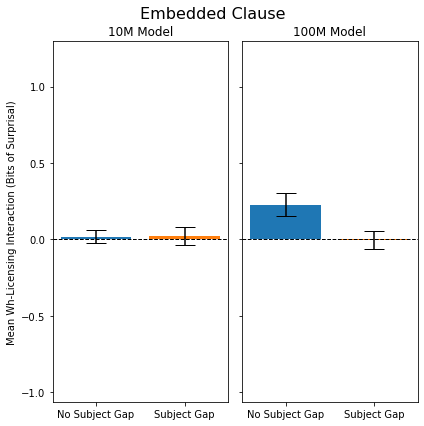

In [21]:
no_subject_gap_df = sentence_df[~((sentence_df['subject_gap'] == 1))]
subject_gap_df = sentence_df[(sentence_df['subject_gap'] == 1)]
no_gap_wh_effect_df_10m = compute_wh_licensing_interaction_double_gap(no_subject_gap_df, 'embed_surprisal_10m')
gap_wh_effect_df_10m = compute_wh_licensing_interaction_double_gap(subject_gap_df, 'embed_surprisal_10m')
no_gap_wh_effect_df_100m = compute_wh_licensing_interaction_double_gap(no_subject_gap_df, 'embed_surprisal_100m')
gap_wh_effect_df_100m = compute_wh_licensing_interaction_double_gap(subject_gap_df, 'embed_surprisal_100m')
df_list_10m = [no_gap_wh_effect_df_10m, gap_wh_effect_df_10m]
df_list_100m = [no_gap_wh_effect_df_100m, gap_wh_effect_df_100m]
plot_wh_licensing_interaction(df_list_10m, '10M Model', df_list_100m, '100M Model', ['No Subject Gap', 'Subject Gap'], 'Embedded Clause')

#### Wh-Islands

In [ ]:
sentence_df = pd.read_csv('test_sentences/Wh-Islands.csv')

In [ ]:
sentence_df[['continuation', 'end']] = sentence_df['continuation'].apply(split_ends)
sentence_df = encode_wh_licensor(sentence_df)
sentence_df['gap_numeric'] = sentence_df['gap'].replace(0, -1)
sentence_df['sentence'] = sentence_df.apply(merge_sentence, axis = 1)
sentence_df['surprisals_10m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_10m, x))
sentence_df['surprisals_100m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_100m, x))

Post Gap Region - Continuation

In [ ]:
sentence_df['region_surprisal_10m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_10m', ['continuation']), axis = 1)
sentence_df['region_surprisal_100m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_100m', ['continuation']), axis = 1)

In [ ]:
null_comp_df = sentence_df[(sentence_df['island_type'] == 'null_comp')]
that_comp_df = sentence_df[(sentence_df['island_type'] == 'that_comp')]
wh_comp_df = sentence_df[(sentence_df['island_type'] == 'wh_comp')]
null_comp_wh_effect_df_10m = compute_wh_licensing_interaction(null_comp_df, 'region_surprisal_10m')
that_comp_wh_effect_df_10m = compute_wh_licensing_interaction(that_comp_df, 'region_surprisal_10m')
wh_comp_wh_effect_df_10m = compute_wh_licensing_interaction(wh_comp_df, 'region_surprisal_10m')
null_comp_wh_effect_df_100m = compute_wh_licensing_interaction(null_comp_df, 'region_surprisal_100m')
that_comp_wh_effect_df_100m = compute_wh_licensing_interaction(that_comp_df, 'region_surprisal_100m')
wh_comp_wh_effect_df_100m = compute_wh_licensing_interaction(wh_comp_df, 'region_surprisal_100m')
df_list_10m = [null_comp_wh_effect_df_10m, that_comp_wh_effect_df_10m, wh_comp_wh_effect_df_10m]
df_list_100m = [null_comp_wh_effect_df_100m, that_comp_wh_effect_df_100m, wh_comp_wh_effect_df_100m]
plot_wh_licensing_interaction(df_list_10m, '10M Model', df_list_100m, '100M Model', ['null-comp', 'that-comp', 'wh-comp'], 'Post-Gap Region')

Embedded Clause

In [ ]:
embed = ['compl', 'embed 1', 'whether', 'subj 2', 'vp 2', 'obj_2', 'continuation', 'end']
sentence_df['embed_surprisal_10m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_10m', embed, normalize = True), axis = 1)
sentence_df['embed_surprisal_100m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_100m', embed, normalize = True), axis = 1)

In [ ]:
null_comp_df = sentence_df[(sentence_df['island_type'] == 'null_comp')]
that_comp_df = sentence_df[(sentence_df['island_type'] == 'that_comp')]
wh_comp_df = sentence_df[(sentence_df['island_type'] == 'wh_comp')]
null_comp_wh_effect_df_10m = compute_wh_licensing_interaction(null_comp_df, 'embed_surprisal_10m')
that_comp_wh_effect_df_10m = compute_wh_licensing_interaction(that_comp_df, 'embed_surprisal_10m')
wh_comp_wh_effect_df_10m = compute_wh_licensing_interaction(wh_comp_df, 'embed_surprisal_10m')
null_comp_wh_effect_df_100m = compute_wh_licensing_interaction(null_comp_df, 'embed_surprisal_100m')
that_comp_wh_effect_df_100m = compute_wh_licensing_interaction(that_comp_df, 'embed_surprisal_100m')
wh_comp_wh_effect_df_100m = compute_wh_licensing_interaction(wh_comp_df, 'embed_surprisal_100m')
df_list_10m = [null_comp_wh_effect_df_10m, that_comp_wh_effect_df_10m, wh_comp_wh_effect_df_10m]
df_list_100m = [null_comp_wh_effect_df_100m, that_comp_wh_effect_df_100m, wh_comp_wh_effect_df_100m]
plot_wh_licensing_interaction(df_list_10m, '10M Model', df_list_100m, '100M Model', ['null-comp', 'that-comp', 'wh-comp'], 'Embedded Clause')

#### Adjunct Islands 

In [ ]:
sentence_df = pd.read_csv('test_sentences/Adjunct Islands.csv')

In [ ]:
sentence_df[['continuation', 'end']] = sentence_df['continuation'].apply(split_ends)
sentence_df = encode_wh_licensor(sentence_df)
sentence_df['gap_numeric'] = sentence_df['gap'].replace(0, -1)
sentence_df['sentence'] = sentence_df.apply(merge_sentence, axis = 1)
sentence_df['surprisals_10m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_10m, x))
sentence_df['surprisals_100m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_100m, x))

Post-Gap Region - Continuation

In [ ]:
sentence_df['region_surprisal_10m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_10m', ['continuation']), axis = 1)
sentence_df['region_surprisal_100m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_100m', ['continuation']), axis = 1)

In [ ]:
object_df = sentence_df[(sentence_df['island_type'] == 'object')]
adjunct_back_df = sentence_df[(sentence_df['island_type'] == 'adjunct_back')]
adjunct_front_df = sentence_df[(sentence_df['island_type'] == 'adjunct_front')]
object_wh_effect_df_10m = compute_wh_licensing_interaction(object_df, 'region_surprisal_10m')
adjunct_back_wh_effect_df_10m = compute_wh_licensing_interaction(adjunct_back_df, 'region_surprisal_10m')
adjunct_front_wh_effect_df_10m = compute_wh_licensing_interaction(adjunct_front_df, 'region_surprisal_10m')
object_wh_effect_df_100m = compute_wh_licensing_interaction(object_df, 'region_surprisal_100m')
adjunct_back_wh_effect_df_100m = compute_wh_licensing_interaction(adjunct_back_df, 'region_surprisal_100m')
adjunct_front_wh_effect_df_100m = compute_wh_licensing_interaction(djunct_front_df, 'region_surprisal_100m')
df_list_10m = [object_wh_effect_df_10m, adjunct_back_wh_effect_df_10m, adjunct_front_wh_effect_df_10m]
df_list_100m = [object_wh_effect_df_100m, adjunct_back_wh_effect_df_100m, adjunct_front_wh_effect_df_100m]
plot_wh_licensing_interaction(df_list_10m, '10M Model', df_list_100m, '100M Model', ['Object Position', 'Adjunct Back', 'Adjunct Front'], 'Post-Gap Region')

Embedded Clause

In [ ]:
embed = ['adjunct setup', 'subject', 'modifier', 'verb', 'object', 'end']
sentence_df['embed_surprisal_10m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_10m', embed, normalize = True), axis = 1)
sentence_df['embed_surprisal_100m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_100m', embed, normalize = True), axis = 1)

In [ ]:
object_df = sentence_df[(sentence_df['island_type'] == 'object')]
adjunct_back_df = sentence_df[(sentence_df['island_type'] == 'adjunct_back')]
adjunct_front_df = sentence_df[(sentence_df['island_type'] == 'adjunct_front')]
object_wh_effect_df_10m = compute_wh_licensing_interaction(object_df, 'embed_surprisal_10m')
adjunct_back_wh_effect_df_10m = compute_wh_licensing_interaction(adjunct_back_df, 'embed_surprisal_10m')
adjunct_front_wh_effect_df_10m = compute_wh_licensing_interaction(adjunct_front_df, 'embed_surprisal_10m')
object_wh_effect_df_100m = compute_wh_licensing_interaction(object_df, 'embed_surprisal_100m')
adjunct_back_wh_effect_df_100m = compute_wh_licensing_interaction(adjunct_back_df, 'embed_surprisal_100m')
adjunct_front_wh_effect_df_100m = compute_wh_licensing_interaction(djunct_front_df, 'embed_surprisal_100m')
df_list_10m = [object_wh_effect_df_10m, adjunct_back_wh_effect_df_10m, adjunct_front_wh_effect_df_10m]
df_list_100m = [object_wh_effect_df_100m, adjunct_back_wh_effect_df_100m, adjunct_front_wh_effect_df_100m]
plot_wh_licensing_interaction(df_list_10m, '10M Model', df_list_100m, '100M Model', ['Object Position', 'Adjunct Back', 'Adjunct Front'], 'Embedded Clause')

#### Complex NP Islands

In [ ]:
sentence_df = pd.read_csv('test_sentences/Complex NP Islands.csv')

In [ ]:
sentence_df = encode_wh_licensor(sentence_df)
sentence_df['gap_numeric'] = sentence_df['gap'].replace(0, -1)
sentence_df['sentence'] = sentence_df.apply(merge_sentence, axis = 1)
sentence_df['surprisals_10m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_10m, x))
sentence_df['surprisals_100m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_100m, x))

Subject Condition

In [ ]:
subject_df = sentence_df.copy()

In [ ]:
subject_df['region_surprisal_10m'] = subject_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_10m', ['subj_setup']), axis = 1)
subject_df['region_surprisal_100m'] = subject_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_100m', ['subj_setup']), axis = 1)

In [ ]:
# filter for subject condition
subject_df = subject_df[subject_df['subj_obj'] == 'subject']

Object Condition

In [ ]:
object_df = sentence_df.copy()

In [ ]:
object_df['region_surprisal_10m'] = object_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_10m', ['end']), axis = 1)
object_df['region_surprisal_100m'] = object_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_100m', ['end']), axis = 1)

In [ ]:
# filter for object gap
object_df = object_df[object_df['subj_obj'] == 'object']

Embedded Clause

In [ ]:
embed = ['subj', 'that_rc', 'what_rc', 'rc_np', 'prep', 'prep_np', 'subj_setup', 'obj_setup', 'end']
sentence_df['embed_surprisal_10m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_10m', embed, normalize = True), axis = 1)
sentence_df['embed_surprisal_100m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_100m', embed, normalize = True), axis = 1)

Embedded Clause - Subject Condition

In [ ]:
# filter for subject condition
subject_df = sentence_df[sentence_df['subj_obj'] == 'subject']

Embedded Clause - Object Condition

In [ ]:
# filter for object gap
object_df = sentence_df[sentence_df['subj_obj'] == 'object']